## Start with a simple power law model
- Form: $\bar{\gamma_{IA}} = Ar_{p}^{\beta}$

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

# import measured data
data_dir = '/home/b7009348/WGL_project/DES-data/'
jackknife_data  = np.load(data_dir+'ia_jackknife_values-bin_slop=0.npz')
full_data = np.load(data_dir+'ia_full_values-bin_slop=0.npz')

# select parts of data needed for fitting
data_points = full_data['IA']
cov = jackknife_data['IA_cov']
sig = np.sqrt(np.diag(cov))
inv_cov = np.linalg.pinv(cov)

# define separation vectors
theta = np.logspace(np.log10(2.82895008), np.log10(224.6485775),20)
thetaX = np.logspace(np.log10(2.5),np.log10(250),500)
theta0 = theta[9]
print(theta, theta0)

[  2.82895008   3.56138466   4.48345157   5.64424793   7.10558242
   8.94526644  11.26125727  14.17687401  17.84736392  22.46816884
  28.28533184  35.60859823  44.82790852  56.43416146  71.0453529
  89.43948199 112.59597726 141.74784796 178.44733791 224.6485775 ] 22.468168836547523


In [2]:
import scipy.linalg

e = scipy.linalg.eigvalsh(cov)

print(e/e.max())

patch_data = jackknife_data['IA']

scipy.linalg.svdvals(patch_data)

[4.26715406e-18 2.43001895e-05 7.43536503e-05 5.92637209e-04
 1.04131050e-03 1.96850495e-03 3.15899792e-03 4.52652756e-03
 6.96465321e-03 8.96247063e-03 1.77781626e-02 1.95941747e-02
 3.09431700e-02 4.17109041e-02 4.71110074e-02 9.51701948e-02
 1.55098870e-01 2.05539405e-01 3.41682904e-01 1.00000000e+00]


array([1.00249118e-02, 5.09614406e-04, 4.24136445e-04, 3.82337886e-04,
       2.72074658e-04, 2.23159330e-04, 1.79581288e-04, 1.68991729e-04,
       1.28103002e-04, 1.19139079e-04, 8.16193790e-05, 7.68123928e-05,
       5.85855808e-05, 5.47609278e-05, 4.49125459e-05, 3.80227518e-05,
       2.38356655e-05, 1.65535465e-05, 5.91236191e-06, 2.71042978e-06])

In [3]:
# define log_likelihood function
def log_likelihood(free_params, theta, data_points, cov):
    A, B = free_params
    model = A * (theta/theta0)**B
    #print('A : %.6f'%A)
    #print('B : %.6f'%B)
    #print('Theta : %.6f'%theta)
    #print('Theta0 : %.6f'%theta0)
    x = data_points - model
    #print('Data:%.16f'%data_points)
    #print('Model:%.16f'%model)
    #print('sig1:%.16f'%sig1)
    return -0.5 * np.dot(x, np.dot(inv_cov, x))
    #return -0.5 * np.sum((x/sig1)**2)

In [4]:
# define priors. For now not using priors so function just returns 0
def log_prior(free_params):
    A, B = free_params
    return 0

In [5]:
# log probability is combination of priors and likelihood
def log_probability(free_params, theta, data_points, cov):
    lp = log_prior(free_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(free_params, theta, data_points, cov)

In [6]:
# set up walkers, dimensions and starting positions in parmaeter space
nwalkers = 20
ndim = 2

np.random.seed(42)

A_init = 2.4e-4 + 1e-5 * np.random.randn(nwalkers,1)
B_init = -0.7 + 0.3 * np.random.randn(nwalkers,1)
pos = np.hstack([A_init, B_init])

In [7]:
2.4e-3 * (theta[0])**(-0.7)

0.0011589735989176134

In [9]:
log_likelihood(pos[0], theta, data_points, cov)

-307.8442505514264

In [10]:
log_likelihood([2.6e-3, -0.75], theta, data_points, cov)

-27037.616596713717

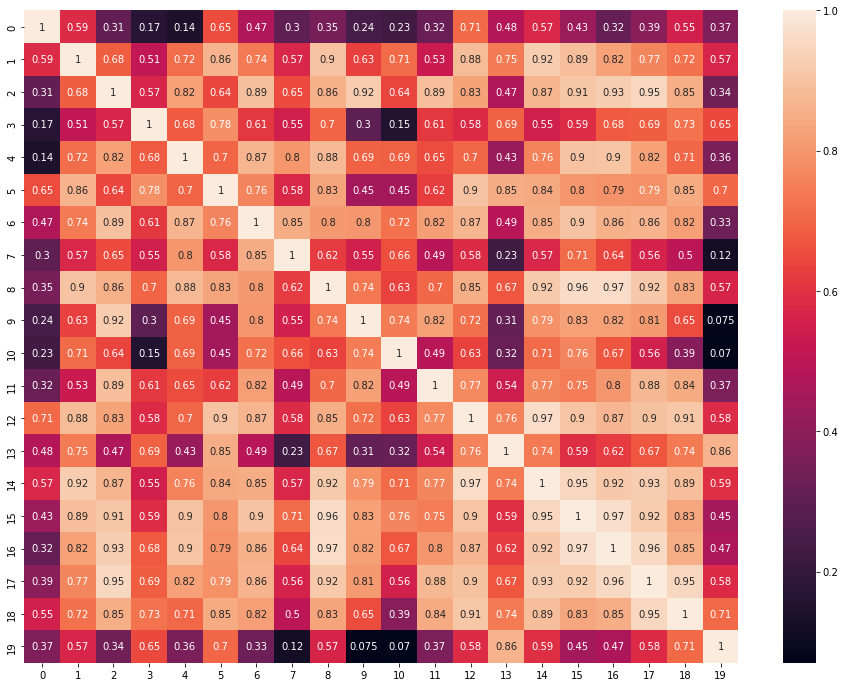

In [11]:
import seaborn as sn

corr = np.corrcoef(cov)

plt.figure(figsize=[16,12])
sn.heatmap(corr, annot=True)
plt.savefig('correlation_matrix.png', dpi=300)

In [12]:
np.random.seed(42)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(theta, data_points, cov))
sampler.run_mcmc(pos, 15000, progress=True);

100%|██████████| 15000/15000 [00:07<00:00, 1951.74it/s]


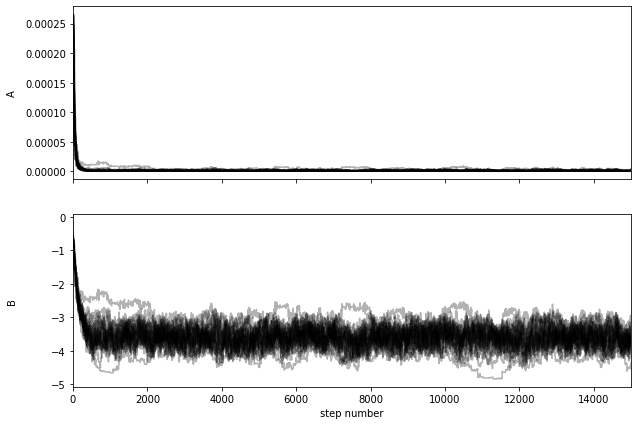

In [13]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A", "B"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig('mcmc_simple_power_chain.png', dpi=200)

(20, 15000, 2)


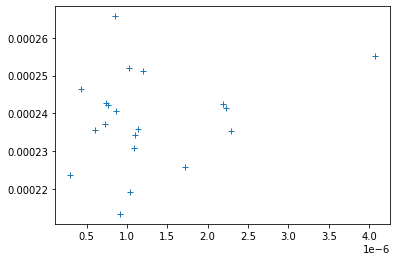

In [14]:
print(sampler.chain.shape)
plt.plot(sampler.chain[:,-1,0], sampler.chain[:,1,0], '+')

In [15]:
sampler.get_log_prob()[:,-1]
list(zip(sampler.get_log_prob()[-1,:], sampler.get_chain()[-1,:]))

[(-148.39083827973602, array([ 2.22291825e-06, -3.28365745e+00])),
 (-146.892753692237, array([ 7.62567971e-07, -3.86551976e+00])),
 (-147.6994186201801, array([ 4.28657853e-07, -4.17075797e+00])),
 (-150.21546783892086, array([ 4.07079174e-06, -2.97963662e+00])),
 (-147.00830328486566, array([ 7.29394742e-07, -3.89321548e+00])),
 (-147.10713165827366, array([ 8.66699136e-07, -3.77455518e+00])),
 (-147.27607651079305, array([ 1.20404723e-06, -3.60452326e+00])),
 (-147.1699415604642, array([ 1.02640654e-06, -3.72192969e+00])),
 (-146.95533292060549, array([ 6.05683889e-07, -3.97207455e+00])),
 (-147.03246455678516, array([ 8.53500889e-07, -3.78487995e+00])),
 (-146.95982771967545, array([ 1.13874792e-06, -3.65626106e+00])),
 (-148.13704370481216, array([ 2.29155595e-06, -3.28977235e+00])),
 (-150.46833435350248, array([ 2.18899847e-06, -3.25772801e+00])),
 (-146.966832154748, array([ 9.1288992e-07, -3.7531341e+00])),
 (-148.2172371232989, array([ 2.99494348e-07, -4.34898908e+00])),
 (-1

In [16]:
[log_probability(val, theta, data_points, cov) for val in sampler.get_chain()[-1,:]]

[-148.39083827973602,
 -146.892753692237,
 -147.6994186201801,
 -150.21546783892086,
 -147.00830328486566,
 -147.10713165827366,
 -147.27607651079305,
 -147.1699415604642,
 -146.95533292060549,
 -147.03246455678516,
 -146.95982771967545,
 -148.13704370481216,
 -150.46833435350248,
 -146.966832154748,
 -148.2172371232989,
 -147.05108671903503,
 -146.92034163499588,
 -146.83820130073286,
 -147.03159786867488,
 -147.48453041667983]

In [17]:
print('Mean acceptance fraction: {0:.3f}'.format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.459


In [18]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: [ 86.74060855 336.35398687]

In [19]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(19860, 2)


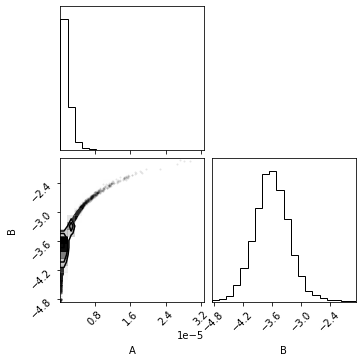

In [20]:
import corner

fig = corner.corner(
        flat_samples, labels=labels
);

In [21]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q  = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.16f}_{{-{1:.16f}}}^{{{2:.16f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

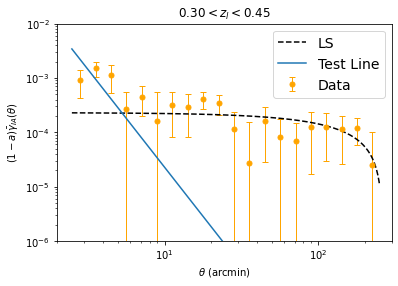

In [23]:
# least squares fit
A = np.vander(theta, 2)
ATA = np.dot(A.T, A / (sig ** 2)[:, None])
w = np.linalg.solve(ATA, np.dot(A.T, data_points / sig ** 2))

#test parameters to visually idenitify where to intialise walkers (roguhly)
Amp = 0.0000012252963574
B = -3.6123176751455648

plt.errorbar(theta, data_points, yerr=sig, lw=0, marker='o', color='orange', markersize=5, elinewidth=1, capsize=3, label='Data')    
plt.plot(thetaX, np.dot(np.vander(thetaX, 2), w), "--k", label="LS")
plt.plot(thetaX, Amp*(thetaX/theta0)**B, label='Test Line')
plt.legend(fontsize=14)
plt.ylim([1e-6, 1e-2])
plt.xlim([2,300])
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\theta$ (arcmin)')
plt.ylabel(r'$(1-a)\bar{\gamma}_{IA}(\theta)$')
plt.title(r'$0.30<z_{l}<0.45$')    
plt.savefig('Least_Squares_test.png',dpi=200)